# Biased Matrix Factorization
As the name suggests, Biased Matrix Factorization introduces **Biases** on both item and user embeddings in order to combat the problem of potential overfitting of which simple Matrix Factorization suffers from. The architecture of the model is exactly the same as Matrix Factorization, the only difference being that *weight decay* is now added as well, which, as a hyperparameter, could be adjusted and experimented with if need be.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 29 15:58:08 2020

@author: Ufkun-Bayram Menderes

This Python Module contains the implementation of Recommender Systems for the 
goodbooks10k dataset based on Biased Matrix Factorization.
Training for model is provided via train.py modul
The Model is implemented in PyTorch.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from load_goodbooks_ds import *
from encode_books import proc_col, encode_data
from train import train_epochs, test_loss
import pandas as pd
from metrics import *

###############################################################################
# 1st part: Loading the goodbooks dataset from the load_goodbooks_ds.py file
# In that file, the dataset is alredy split up into training, validation and test
# sets. 
# train_ratings = Training set, valid_ratings = validation set, test_rating = 
# testset. The training set consists of 80% of the data in the goodbooks10k 
# dataset, while validation and training make up 10% each. 
###############################################################################


# number of users for embeddings = 53424
num_users = train_ratings.user_id.nunique()
# number of books = 10000
num_items = train_ratings.book_id.nunique()
# determine min and max ratings
min_rating = min(ratings["rating"])
max_rating = max(ratings["rating"])
second_highest = max_rating - 1

min_user_id = min(ratings["user_id"])
max_user_id = max(ratings["user_id"])

print("Number of users: {}, Number of books: {}, Min rating: {}, Max rating: {}"
      .format(num_users_total, num_items, min_rating, max_rating))


class Bias_MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        """
        Bias Matrix factorization class which includes includes 
        biases both in the instantiation of an object of this class 
        and the forward pass

        Parameters
        ----------
        num_users : int
            number of users in a given dataset/pandas dataframe
        num_items : int
            number of items in a given dataset/pandas dataframe
        emb_size : int, optional
            embedding size. The default is 100.

        Bias MF object
        -------
        None.

        """
        super(Bias_MF, self).__init__()
        # user embeddings
        self.user_embedding = nn.Embedding(num_users, emb_size)
        # bias embeddings for user
        self.user_bias = nn.Embedding(num_users, 1)
        # item embeddings
        self.item_embedding = nn.Embedding(num_items, emb_size)
        # bias embeddings for item
        self.item_bias = nn.Embedding(num_items, 1)
        self.user_embedding.weight.data.uniform_(0,0.05)
        self.item_embedding.weight.data.uniform_(0,0.05)
        self.user_bias.weight.data.uniform_(-0.01,0.01)
        self.item_bias.weight.data.uniform_(-0.01,0.01)
        
    def forward(self, user, item):
        """
        Forward pass method of the Bias_MF class
        includes biases for both users and items into the computation

        Parameters
        ----------
        user : int
            user and its numerical representation as user_ids
            
        item : int
            items (in this case books) and their numerical representations
            as book_ids

        Returns
        -------
        torch.tensor
            PyTorch tensor containing output of forward pass

        """
        user_vector = self.user_embedding(user)
        item_vector = self.item_embedding(item)
        bias_user = self.user_bias(user).squeeze()
        bias_item = self.item_bias(item).squeeze()
        return (user_vector*item_vector).sum(1) +  bias_user  + bias_item
    
    def recommend(self, user_id, n=150, r=3):
        """
        Recommends n top items to a user 

        Parameters
        ----------
        user_id : int
            integer representation of a user, will be converted to a torch.Tensor
        n : int, optional
            number of top recommendations which we will return.
            The default is 10.
        
        r : int, optional
            Decimal places to which predicted rating shall be rounded up to

        Returns
        -------
        recommendations : list
            list top n recommendations with predicted ratings

        """
        if user_id > max_user_id or user_id < min_user_id:
            raise ValueError("Invalid user ID")
        books = load_books()
        user = torch.tensor([user_id])
        books_recommend = torch.tensor(ratings.book_id.unique().tolist()) - 1
        predictions = model(user, books_recommend).tolist()
        # normalize the ratings since many ratings are over 5.0
        predictions = [i/max(predictions)*max_rating for i in predictions]
        # zip the book_ids and corresponding rating prediction to a list of 
        # (rating, id) tuples
        book_ids = ratings.book_id.unique()
        predictions = list(zip(predictions, book_ids))
        # get the books which the user has alread read
        user_books_read = ratings[ratings.user_id == user]
        # make a list out of the book_id's that user has alread read
        read_list = list(user_books_read.book_id)
        # make an empty list for unread books, fill it with book_ids
        # of books that user has not rated/read yet
        unread_books = []
        for book in predictions:
            if book[1] not in read_list:
                unread_books.append(book)
        # sort the elements according to their rating, top ratings at top
        unread_books = sorted(unread_books, key=lambda book_tuple: book_tuple[0],
                              reverse=True)
        # indice the list on desired top n elements
        top_n_books = unread_books[:n]
        # get book_ids of top n elements
        top_n_book_ids = [books[1] for books in top_n_books]
        # get the full book information of these books from books.csv dataset
        recommended_books = books[books["id"].isin(top_n_book_ids)]
        # make dict out of top_n_books, keys=ratings, values=ids
        book_rating_dict = dict(top_n_books)
        # reverse keys and values s.t. ids are keys, ratings are values
        book_rating_dict = {value:key for key, value in book_rating_dict.items()}
        # make tuples out key, value elements, save them in the new list
        books_list_rev = [(k, v) for k, v in book_rating_dict.items()]
        # add a new dataframe with id, predicted rating tuples
        book_rating_tups = pd.DataFrame(books_list_rev, columns=['id','predicted_rating'])
        # merge both dataframes into one, id's column is common columns
        recommended_books = recommended_books.merge(book_rating_tups)
        # change predicted ratings >= 5.0 to 5
        recommended_books.loc[recommended_books['predicted_rating'] > 5.0, 'predicted_rating'] = 5.0
        # sort the predicted_rating column such that ratings with highest values
        # are at the top with descending order
        recommended_books = recommended_books.sort_values('predicted_rating', ascending=False)
        # round the values for predicted ratings
        recommended_books = recommended_books.round({'predicted_rating':r})
        # create new columns for predicted ratings on a 1-5 scale
        recommended_books['predicted_rating_scaled'] = recommended_books['predicted_rating']
        # round the ratings to zero decimal places so only values from 1-5 exist
        recommended_books = recommended_books.round({'predicted_rating_scaled':0})
        # return recommended books
        return recommended_books
        
        


model = Bias_MF(num_users, num_items, emb_size=100)
train_epochs(model, epochs=100, lr=0.01, wd=1e-6)


test_users = torch.LongTensor(test_ratings.user_id.values)
test_books = torch.LongTensor(test_ratings.book_id.values)
test_predictions = model(test_users, test_books)

# Normalize test predictions
test_predictions = test_predictions.tolist()
test_predictions = [i/max(test_predictions)*max_rating for i in test_predictions]
# round the predictions to zero decimal places
test_predictions = list(np.around(test_predictions, 0))



Number of users: 53424, Number of books: 10000, Min rating: 1, Max rating: 5
Epoch:0, Loss:15.360435485839844
Epoch:1, Loss:14.76078987121582
Epoch:2, Loss:14.032078742980957
Epoch:3, Loss:13.184896469116211
Epoch:4, Loss:12.230961799621582
Epoch:5, Loss:11.184028625488281
Epoch:6, Loss:10.060667037963867
Epoch:7, Loss:8.880870819091797
Epoch:8, Loss:7.668707847595215
Epoch:9, Loss:6.4524102210998535
Epoch:10, Loss:5.264852046966553
Epoch:11, Loss:4.143182754516602
Epoch:12, Loss:3.1281239986419678
Epoch:13, Loss:2.2619168758392334
Epoch:14, Loss:1.5845947265625
Epoch:15, Loss:1.1275147199630737
Epoch:16, Loss:0.9038820266723633
Epoch:17, Loss:0.8985734581947327
Epoch:18, Loss:1.062218427658081
Epoch:19, Loss:1.3166946172714233
Epoch:20, Loss:1.573978066444397
Epoch:21, Loss:1.7604564428329468
Epoch:22, Loss:1.834276556968689
Epoch:23, Loss:1.789122462272644
Epoch:24, Loss:1.646570086479187
Epoch:25, Loss:1.4436423778533936
Epoch:26, Loss:1.220861792564392
Epoch:27, Loss:1.013492107391

### Recommending items for a random user
Now, just, as before, I will recommend items to a randomly chosen user

In [2]:
model.recommend(1500)

,id,isbn,authors,year,title,avg_rating,predicted_rating,predicted_rating_scaled
125,8946,9646534783,Hafez,1380.0,The Divan,4.63,5.000,5.0
99,7844,60198818,Ramachandra Guha,2007.0,India After Gandhi: The History of the World's...,4.34,4.883,5.0
147,9842,1250058902,Brandon Stanton,2015.0,Humans of New York: Stories,4.50,4.838,5.0
52,5207,836217357,Bill Watterson,1993.0,The Days Are Just Packed: A Calvin and Hobbes ...,4.68,4.811,5.0
98,7831,9770148083,"ØµÙØ§Ø­ Ø¬Ø§ÙÙÙ, ÙØ­ÙÙ Ø­ÙÙ",1963.0,Ø±Ø¨Ø§Ø¹ÙØ§Øª ØµÙØ§Ø­ Ø¬Ø§ÙÙÙ,4.43,4.810,5.0
...,...,...,...,...,...,...,...,...
64,6435,684813785,Richard Rhodes,1986.0,The Making of the Atomic Bomb,4.32,4.364,4.0
19,2613,NaN,Chimamanda Ngozi Adichie,2014.0,We Should All Be Feminists,4.47,4.363,4.0
60,6070,374266514,"Jostein Gaarder, Sarah Jane Hails",1990.0,The Solitaire Mystery: A Novel About Family an...,4.16,4.362,4.0
58,5730,802131808,"Sadegh Hedayat, D.P. Costello",1937.0,The Blind Owl,3.99,4.362,4.0


Surprisingly, the test (i.e. validation loss) is just as low as the Matrix Factorization model, and the training loss seems to converge equally fast and is about the same at the 100th epoch, so both models seem to perform equally good on the test data. For further comparison, we must now consider the performance of both models on the test data. But first we will visualize the embeddings.

### Visualizing embedding weights

In [4]:
# Extract embeddings
book_embeddings = model.item_embedding
book_emb_weights = model.item_embedding.weight.detach().numpy()

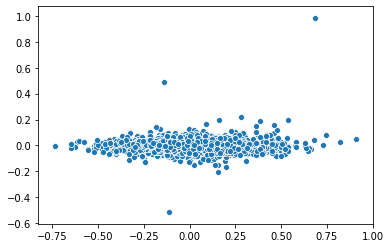

In [5]:
# Visualizing Embedding weights
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_emb_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [7]:
book_emb_weights = book_emb_weights / np.linalg.norm(book_emb_weights, axis = 1).reshape((-1, 1))
book_emb_weights[0][:10]
np.sum(np.square(book_emb_weights[0]))

1.0

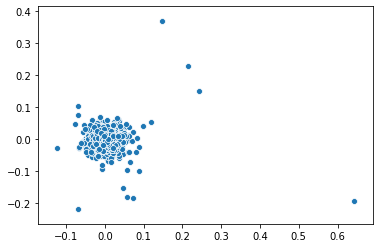

In [8]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_emb_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

It is worth noting that both Matrix Factorization models have very similar distribution of embedding weights and that some outliers can be clearly spotted, while the bulk of the weights clearly centers around a certain space. This could potentially explain the good results for the test loss of both.

## Evaluating the system 
In the next part, just as with the simple Matrix Factorization model, I will evaluate the performance of the Biased Matrix Factorization model on the test dataset. First, we will measure how far on average the predicted ratings are, but before that summary:

In [58]:
from sklearn.metrics import classification_report
true_ratings = test_ratings.rating
print(sklearn.metrics.classification_report(true_ratings, test_predictions, labels=[1, 2, 3, 4, 5], zero_division=0))

              precision    recall  f1-score   support

           1       0.02      0.01      0.01      1792
           2       0.06      0.22      0.10      6259
           3       0.25      0.70      0.37     24420
           4       0.37      0.08      0.14     36094
           5       0.24      0.00      0.00     29811

    accuracy                           0.22     98376
   macro avg       0.19      0.20      0.12     98376
weighted avg       0.27      0.22      0.15     98376



In [59]:
r1_count = test_predictions.count(1)
r2_count = test_predictions.count(2)
r3_count = test_predictions.count(3)
r4_count = test_predictions.count(4)
r5_count = test_predictions.count(5)

print("Total count of rating class 1 predicted: {}".format(r1_count))
print("Total count of rating class 2 predicted: {}".format(r2_count))
print("Total count of rating class 3 predicted: {}".format(r3_count))
print("Total count of rating class 4 predicted: {}".format(r4_count))
print("Total count of rating class 5 predicted: {}".format(r5_count))

Total count of rating class 1 predicted: 561
Total count of rating class 2 predicted: 21176
Total count of rating class 3 predicted: 68274
Total count of rating class 4 predicted: 8328
Total count of rating class 5 predicted: 37


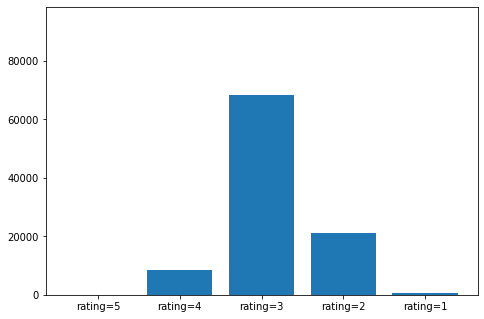

In [60]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ymax = len(test_ratings.rating)
ymin = 0
ax.set_ylim([ymin,ymax])
ratings = ['rating=5', 'rating=4', 'rating=3', 'rating=2', 'rating=1']
counts = [r5_count, r4_count, r3_count, r2_count, r1_count]
ax.bar(ratings,counts)
plt.show()

In [61]:
regression_loss_bmf = regression_loss(test_predictions)
print("The regression loss for the MF model on the test data is: {}".format(regression_loss_bmf))

The regression loss for the MF model on the test data is: 1.2351081564609254


As it visible from the value of the 1.23 for the regression loss, the Biased Matrix Factorizaiton provides a better generalization of the model and doesn't overfit quite as much as the simple Matrix Factorization model does. However, it is still off by 1.2 on a rating scale merely ranging from 1-5, which could influence the final recommendations and especially their ordering due to aforementioned ordering of recommendations by their value for predicted ratings. Now onto analyzing how off the system really predicts the ratings:

In [62]:
# First, we will analyze how many ratings are off by one
class_loss = classification_loss(test_predictions, diff=1)
print("Total amount of correctly predicted ratings: {}".format(len(test_ratings.rating) - class_loss[0]))
print("Total amount of incorrectly predicted ratings: {}".format(class_loss[0]))
print("Accuracy of the model in percent: {:.2f}%".format(class_loss[1]))
print("Predictions off by one: {}".format(class_loss[2]))
print("Percentage of ratings off by one out of all the test data: {:.2f}%".format(class_loss[3]*100))
print("Percentage of ratings off by one out of incorrectly predicted ratings: {:.2f}%".format(class_loss[4]*100))

Total amount of correctly predicted ratings: 21481
Total amount of incorrectly predicted ratings: 76895
Accuracy of the model in percent: 21.84%
Predictions off by one: 39527
Percentage of ratings off by one out of all the test data: 40.18%
Percentage of ratings off by one out of incorrectly predicted ratings: 51.40%


Here, we can notice further improvements from the simple Matrix Factorization system, as the Bias MF system is now able to (at least) predict roughly 22% of the test data correctly. This further underlines the notion that the adding Biases improves generalization of the model and prevents extreme overfitting. The predictions off by "just" one are also considerable, which means that the Bias MF model manages to predict ratings that are extremely off from their ground truths. Now we will analyze how it performed for the other differences:

In [63]:
class_loss_two = classification_loss(test_predictions, diff=2)
print("Predictions off by two: {}".format(class_loss_two[2]))
print("Percentage of ratings off by two out of all the test data: {:.2f}%".format(class_loss_two[3]*100))
print("Percentage of ratings off by two out of incorrectly predicted ratings: {:.2f}%".format(class_loss_two[4]*100))

Predictions off by two: 30322
Percentage of ratings off by two out of all the test data: 30.82%
Percentage of ratings off by two out of incorrectly predicted ratings: 39.43%


In [64]:
#Ratings off by three
class_loss_three = classification_loss(test_predictions, diff=3)
print("Predictions off by three: {}".format(class_loss_three[2]))
print("Percentage of ratings off by three out of all the test data: {:.2f}%".format(class_loss_three[3]*100))
print("Percentage of ratings off by three out of incorrectly predicted ratings: {:.2f}%".format(class_loss_three[4]*100))

Predictions off by three: 6850
Percentage of ratings off by three out of all the test data: 6.96%
Percentage of ratings off by three out of incorrectly predicted ratings: 8.91%


In [65]:
# Ratings off by four 
class_loss_four = classification_loss(test_predictions, diff=4)
print("Predictions off by four: {}".format(class_loss_four[2]))
print("Percentage of ratings off by four out of all the test data: {:.2f}%".format(class_loss_four[3]*100))
print("Percentage of ratings off by four out of incorrectly predicted ratings: {:.2f}%".format(class_loss_four[4]*100))

Predictions off by four: 196
Percentage of ratings off by four out of all the test data: 0.20%
Percentage of ratings off by four out of incorrectly predicted ratings: 0.25%


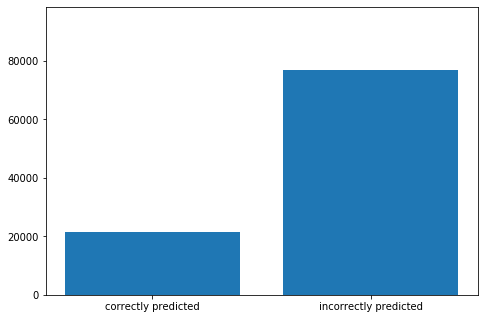

In [66]:
# Plotting the data to show difference between correctly and incorrectly predicted ratings
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ymax = len(test_ratings.rating)
ymin = 0
ax.set_ylim([ymin,ymax])
correct = ymax - class_loss[0]
offs = ['correctly predicted', 'incorrectly predicted']
counts = [correct, class_loss[0]]
ax.bar(offs,counts)
plt.show()

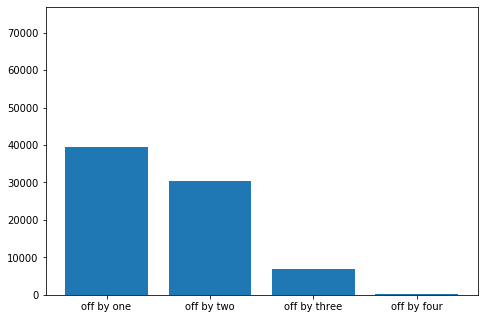

In [67]:
# Plotting the amount of ratings that were off by 1, 2, 3, 4 respectively out of all incorrectly predicted ratings
fig2 = plt.figure()
ax2 = fig2.add_axes([0,0,1,1])
ymax = class_loss[0]
ymin = 0
ax2.set_ylim([ymin,ymax])
offs = ['off by one', 'off by two', 'off by three', 'off by four']
counts = [class_loss[2],class_loss_two[2], class_loss_three[2], class_loss_four[2]]
ax2.bar(offs,counts)
plt.show()

As it can be seen both from the actual values and the plots, the system doesn't get the ratings awfully off (i.e. off by three or four), but it still manages to predict ratings which are the complete opposite, which is not desirable. Still, it is an improvement over the Matrix Factorization model.

In [68]:
import sklearn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_ratings.rating, test_predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
# Diagonal values are accuracies for each rating class

array([5.58035714e-03, 2.17926186e-01, 6.98034398e-01, 8.45569901e-02,
       3.01901982e-04])

Now we will look at the Recall values of the system:

In [69]:
# Recalls 
recall_five = recall_per(test_predictions, 5)
recall_four = recall_per(test_predictions, 4)
recall_three = recall_per(test_predictions, 3)
recall_two = recall_per(test_predictions, 2)
recall_one = recall_per(test_predictions, 1)
recall_total = recall_macro_avg(test_predictions)

print("Recall for rating 5: {:.3f}%".format(recall_five))
print("Recall for rating 4: {:.3f}%".format(recall_four))
print("Recall for rating 3: {:.3f}%".format(recall_three))
print("Recall for rating 2: {:.3f}%".format(recall_two))
print("Recall for rating 1: {:.3f}%".format(recall_one))
print("Total macro averaged recall: {:.3f}%".format(recall_total))

Recall for rating 5: 0.030%
Recall for rating 4: 8.456%
Recall for rating 3: 69.803%
Recall for rating 2: 21.793%
Recall for rating 1: 0.558%
Total macro averaged recall: 20.128%


The data for recall shows that the Biased MF model clearly struggled with the predictions for the rating class 5 and the rating class 1 right. However, the performance for the rating class 3 is by far the best and nearly two thirds of the truth labels of this rating class were correctly identified. This may come as a surprise since rating class 4 was the label class which had the highest occurence among the test ratings. However, as the uppermost plot shows, this may be a consequence of the fact that rating class 3 has been by far predicted the most

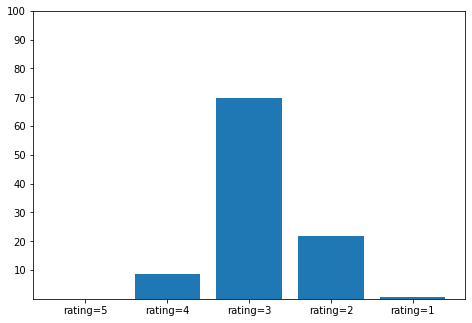

In [70]:
# Plotting the recall
fig3 = plt.figure()
ax3 = fig3.add_axes([0,0,1,1])
ticks = [10,20,30,40,50,60, 70, 80, 90, 100]
ax3.set_yticks(ticks)
ymax = 100
ymin = 0
ax3.set_ylim([ymin,ymax])
ratings = ['rating=5', 'rating=4', 'rating=3', 'rating=2', 'rating=1']
counts = [recall_five, recall_four, recall_three, recall_two, recall_one]
ax3.bar(ratings,counts)
plt.show()

The next metric to be analyzed is the 

In [71]:
##Analyzing precisions
precision_five = precision_per(test_predictions, 5)
precision_four = precision_per(test_predictions, 4)
precision_three = precision_per(test_predictions, 3)
precision_two = precision_per(test_predictions, 2)
precision_one = precision_per(test_predictions, 1)
precision_total = precision_macro_avg(test_predictions)

print("Precision for rating 5: {:.3f}%".format(precision_five*100))
print("Precision for rating 4: {:.3f}%".format(precision_four*100))
print("Precision for rating 3: {:.3f}%".format(precision_three*100))
print("Precision for rating 2: {:.3f}%".format(precision_two*100))
print("Precision for rating 1: {:.3f}%".format(precision_one*100))
print("Total macro averaged precision: {:.3f}%".format(precision_total*100))

Precision for rating 5: 24.324%
Precision for rating 4: 36.647%
Precision for rating 3: 24.967%
Precision for rating 2: 6.441%
Precision for rating 1: 1.783%
Total macro averaged precision: 18.833%


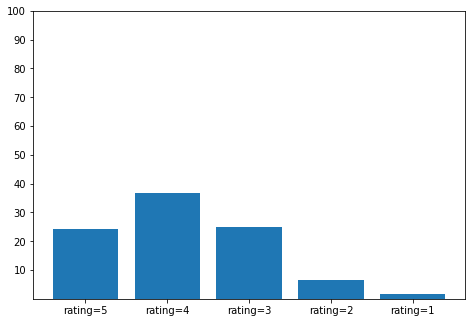

In [72]:
##Plotting precisions
fig4 = plt.figure()
ax4 = fig4.add_axes([0,0,1,1])
ax4.set_yticks(ticks)
ymax = 100
ymin = 0
ax4.set_ylim([ymin,ymax])
ratings = ['rating=5', 'rating=4', 'rating=3', 'rating=2', 'rating=1']
counts = [precision_five*100, precision_four*100, precision_three*100, precision_two*100, precision_one*100]
ax4.bar(ratings,counts)
plt.show()

With precision, the system struggles least with rating class 4, potentially it's the most often occurring true label in the test data, but again low performance on the rating class 1 and 2 can be observed. 

In [73]:
from sklearn.metrics import f1_score


f_five =  0.0
f_four = 0.14
f_three = 0.37
f_two = 0.10
f_one = 0.01 #f_measure_per function will cause a ZeroDivisionError
# because of this, I will add up the percentages and divide them  by the number of output (i.e. rating) classes
f_total = f1_score(test_ratings.rating, test_predictions, average='macro')
f1_total_weighted = f1_score(test_ratings.rating, test_predictions, average='weighted')
f1_total_micro = f1_score(test_ratings.rating, test_predictions, average='micro')


print("F1-measure for rating class 5: {:.3f}%".format(f_five*100))
print("F1-measure for rating class 4: {:.3f}%".format(f_four*100))
print("F1-measure for rating class 3: {:.3f}%".format(f_three*100))
print("F1-measure for rating class 2: {:.3f}%".format(f_two*100))
print("F1-measure total for the test set macro-averaged: {:.3f}%".format(f_total*100))
print("Weighted F1-measure for the test set {:.3f}%".format(f1_total_weighted*100))
print("Weighted F1-measure for the test set micro-averaged: {:.3f}%".format(f1_total_micro*100))

F1-measure for rating class 5: 0.000%
F1-measure for rating class 4: 14.000%
F1-measure for rating class 3: 37.000%
F1-measure for rating class 2: 10.000%
F1-measure total for the test set macro-averaged: 12.275%
Weighted F1-measure for the test set 14.838%
Weighted F1-measure for the test set micro-averaged: 21.836%


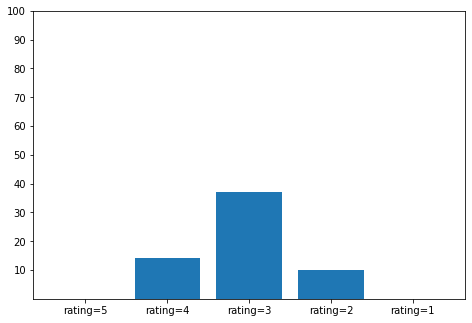

In [74]:
# Plotting the f-measures
fig5 = plt.figure()
ax5 = fig5.add_axes([0,0,1,1])
ax5.set_yticks(ticks)
ymax = 100
ymin = 0
ax5.set_ylim([ymin,ymax])
ratings = ['rating=5', 'rating=4', 'rating=3', 'rating=2', 'rating=1']
counts = [f_five*100, f_four*100, f_three*100, f_two*100, 0]
ax5.bar(ratings,counts)
plt.show()

The dismal f-measures for rating 1 and rating further underline the fact that the Biased MF model greatly struggled with the minimum and maximum rating class, while it performed well on the ratings inbetween them, particularly rating class 3. This may however be a result of the fact that the Bias MF clearly has a preference for predicting rating class 3. 

## Conclusion
While better than the simple Matrix Factorization model, the Bias MF model still seems to have a lot of issues on unseen data, although performing similarly well on training and validation data. Nonetheless, the added biases are in fact helpful in preventing overfitting for the model since the accuracy has visibly improved thanks to the addition of them in the forward pass. This begs the question whether a model based on **Neural Network** architecture could even further improve performance.